# Project: AI-generated text detection 🤖
--------------------------------

**Dr. Dave Wanik - (OPIM 5512: Data Science Using Python) AND (OPIM 5509: Introduction to Deep Learning) - University of Connecticut**

Can you predict the 'ind' (0= human, 1 = AI) as a function of the 768 document embeddings, the word count and the punctuation? Be careful - there is imbalanced data which may require some advanced methods in order to get a reasonable model. Can you beat a naive (majority class) model or logistic regression? Now is your time to shine and apply everything you learned.

This project is being given to both classes simultaneously - however, you should only use the methods taught in each class. DS students must use only `sklearn` models, DL students must use `keras` models taught in class. DS students may use `XGBoost()` if they want, but this is at their own risk. `autoML` and `autokeras` may be used to fit models, but students still must be rigorous in their evaluation of the models.

Come to office hours EARLY with any questions that might pop up. See end of notebook for rubric.



*   Best F1 score on the test data was:
  **0.7537**



# Data
* Raw data was download from this website:
  * https://bitgrit.net/competition/19

You can download the data directly from the website, HuskyCT or this gdown link.


Just use the `training_set.csv` file - we are ignoring the `test_set.csv` since it does not have labels. On your own, you are welcome to join the bitgrit challenge and submit your scores!

I see the highest value on November 3rd, 2023 is `f1_score = 0.675` on the leaderboard 😉

# Other resources
* https://medium.com/bitgrit-data-science-publication/can-you-detect-ai-generated-text-1f5dd3c97318
* https://deepnote.com/workspace/benthecoder-1aa3f71b-c5ea-44d1-ba14-b7fe4c5507d7/project/article-notebooks-a605a3e6-1564-47b2-94e7-842290ba7692/notebook/ai-gen-text-b5ae35203ae24e00a106db5d785b643f?
* https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
* https://stackoverflow.com/questions/45361559/feature-importance-chart-in-neural-network-using-keras-in-python  

In [ ]:
#install libraries for pdp, ice
!pip install pulp
!pip install pycebox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3625 sha256=dc70ac3ef15e465172a57f527be1bd1f00ef5cc41bdb08f91ea69c96ab0b9621
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.metrics import Metric
import keras

# preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# neural net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

#model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
from pycebox.ice import ice, ice_plot
from sklearn.metrics import accuracy_score, make_scorer

#random seed for reproducibility and consistency
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

## Load Data

Downloading the data using gdown

In [ ]:
!gdown 1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas

Downloading...
From: https://drive.google.com/uc?id=1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas
To: /content/ai-text-competition-data.zip
100% 50.8M/50.8M [00:00<00:00, 236MB/s]


In [ ]:
# unzip it
!unzip ai-text-competition-data.zip

# read it
df = pd.read_csv('/content/ai-text-competition/training_set.csv')

Archive:  ai-text-competition-data.zip
   creating: ai-text-competition/
  inflating: ai-text-competition/solution_format.csv  
  inflating: ai-text-competition/test_set.csv  
  inflating: ai-text-competition/training_set.csv  


In [ ]:
df.shape

(11144, 772)

In [ ]:
#check if there are any null values in any of the columns
df.isna().sum().sum()

0

There are no missing values found in any of the features

In [ ]:
# target class distribution
df['ind'].value_counts()

0    10044
1     1100
Name: ind, dtype: int64

Target class is highly imbalanced. Hence we might have to perform some resampling techniques to balance the data

In [ ]:
df.head(5)

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
0,1,0.231980,-0.190620,-0.985933,-0.233773,-0.355879,-0.488884,0.254773,-0.121213,-0.820528,...,0.101373,0.575414,-0.567646,-0.051293,0.455840,0.065538,0.020671,25,14,0
1,2,0.168223,-1.204551,-0.596952,-0.722583,0.284799,-0.238639,-0.410948,-0.090654,1.220703,...,0.407270,0.769329,0.555820,0.252843,0.603888,1.240028,-0.076253,23,4,0
2,3,0.522005,-0.759933,-1.209413,0.301834,0.361126,0.158161,-0.117013,0.313158,1.102455,...,0.143658,0.874958,0.679421,0.393198,0.439103,0.742181,-0.430493,29,8,0
3,4,0.038746,-1.408335,-0.580810,0.353450,1.142353,-0.418879,-0.134133,-0.199796,1.071100,...,0.728436,0.540930,1.968447,0.185315,0.630167,0.577032,0.117681,14,3,0
4,5,-0.307572,0.103575,-0.368605,-0.378654,-0.285990,-0.508058,-0.254869,-0.108291,-0.095139,...,-0.146845,0.497731,-0.299924,-0.020024,0.975511,-0.342360,-0.428779,35,9,0


## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Columns: 772 entries, ID to ind
dtypes: float64(768), int64(4)
memory usage: 65.6 MB


In [ ]:
# descriptive statistics of all the columns
df.describe()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
count,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,...,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000,11144.000000
mean,5572.500000,0.146012,-0.273505,-0.666907,-0.415562,-0.230934,-0.270790,-0.039869,-0.037003,0.101543,...,0.274985,0.687529,0.269849,0.199639,0.443093,0.078578,-0.062243,29.978643,7.347003,0.098708
std,3217.140034,0.389374,0.382566,0.432605,0.745149,0.583487,0.388663,0.292493,0.246509,0.503054,...,0.406760,0.431843,0.545066,0.304694,0.365657,0.551214,0.300848,10.271548,4.041350,0.298283
min,1.000000,-1.633110,-1.971542,-2.505377,-4.280401,-2.413613,-1.514833,-1.427118,-1.036038,-1.779871,...,-1.765492,-1.723701,-1.506003,-1.272904,-1.467510,-1.605773,-1.085949,5.000000,0.000000,0.000000
25%,2786.750000,-0.111816,-0.517288,-0.954874,-0.891329,-0.633606,-0.536751,-0.229016,-0.197038,-0.236033,...,-0.000389,0.392865,-0.125641,0.000539,0.208861,-0.303969,-0.273816,22.000000,4.000000,0.000000
50%,5572.500000,0.161513,-0.261028,-0.673000,-0.415641,-0.244129,-0.281473,-0.036129,-0.038384,0.068244,...,0.256874,0.683075,0.213906,0.205270,0.461389,0.021472,-0.074150,30.000000,7.000000,0.000000
75%,8358.250000,0.418461,-0.016541,-0.381686,0.078408,0.168207,-0.018891,0.157572,0.117311,0.399803,...,0.535327,0.981356,0.634109,0.400167,0.692926,0.405299,0.129446,38.000000,10.000000,0.000000
max,11144.000000,1.378549,1.376324,1.392311,2.184251,1.659698,1.667419,1.070739,1.320982,2.456948,...,1.987709,1.965830,2.582598,1.375909,1.879438,2.579186,1.674109,57.000000,27.000000,1.000000


Following plots are used to visualize the means and standard deviations of all the embedding features

### Means and standard deviations of embedding features

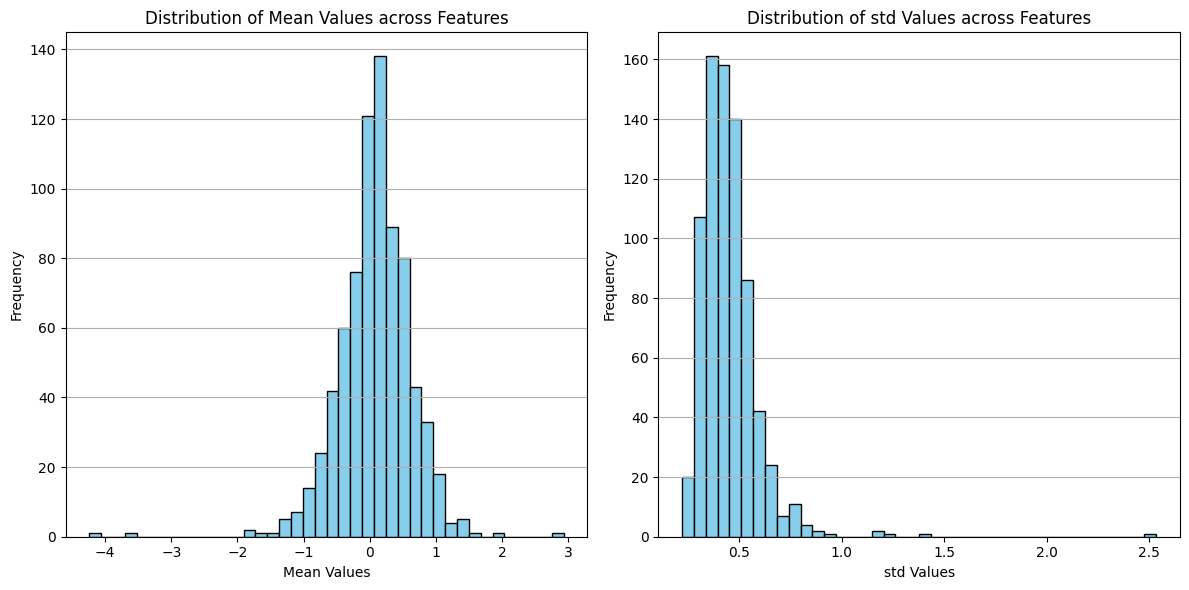

In [ ]:
# plotting graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
feature_cols = [col for col in df.columns if 'feature' in col]
# Calculate the means across the features
feature_means = df[feature_cols].mean()

# Plotting the distribution of feature means

axes[0].hist(feature_means, bins=40, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Mean Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Mean Values across Features')
axes[0].grid(axis='y')


feature_means = df[feature_cols].std()

# Plotting the distribution of feature std's

axes[1].hist(feature_means, bins=40, color='skyblue', edgecolor='black')
axes[1].set_xlabel('std Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of std Values across Features')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


The distribution of means appears to be more concentrated around zero, with a spread that extends between -2 and 2, implies that, on average, the values across features tend to be closer to zero.


The presence of right-skewness in std deviation plot  suggests that a few features exhibit significantly higher variability or have values that are much more spread out compared to the rest.


### Distribution of target variable.

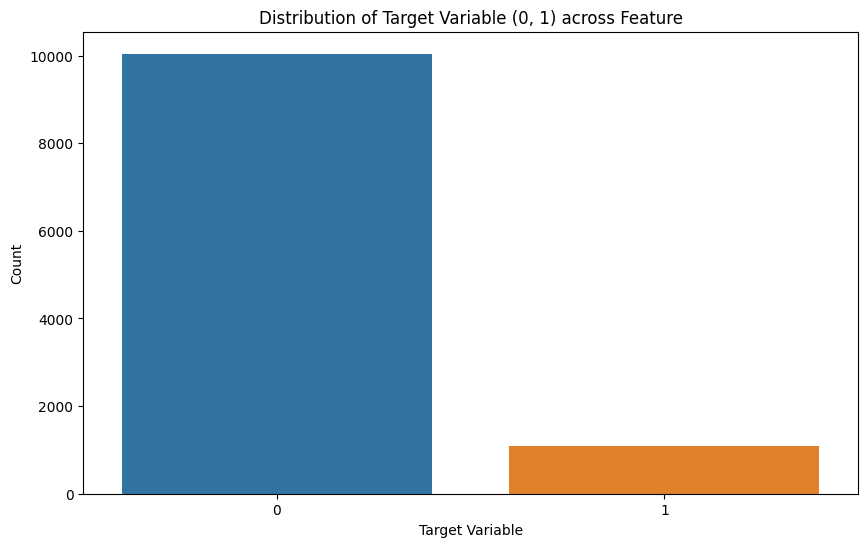

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ind')
plt.title('Distribution of Target Variable (0, 1) across Feature')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()

The histogram representing the target variable highlights a considerable imbalance in the data distribution among its classes.

### Word Count of Human vs AI generated Text

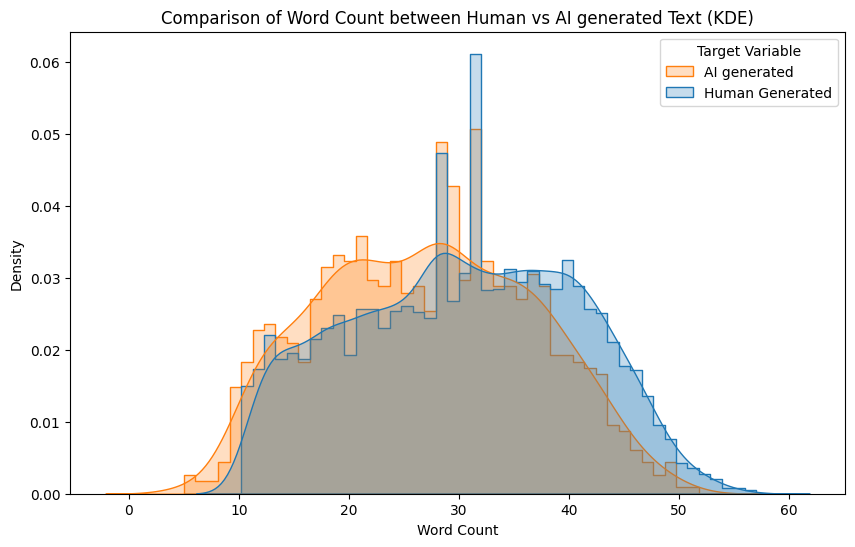

In [ ]:
# KDE plot to compare word count between target variables
plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
# sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", kde=True, bins=50)
sns.histplot(data=df, x='word_count', hue='ind', element="step", common_norm=False, stat="density", bins=50)
sns.kdeplot(data=df, x='word_count', hue='ind', fill=True, common_norm=False)
plt.title('Comparison of Word Count between Human vs AI generated Text (KDE)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Target Variable', labels=['AI generated', 'Human Generated'])
plt.show()

It can be observed that Human generated text has slightly higher number of words than AI generated text. However, there is a huge overlap between word counts of Text generated by Humans and AI. At an average, both human and AI generated text is around 30 words in length.

### Punctuation Count of Human Vs AI Generated Text

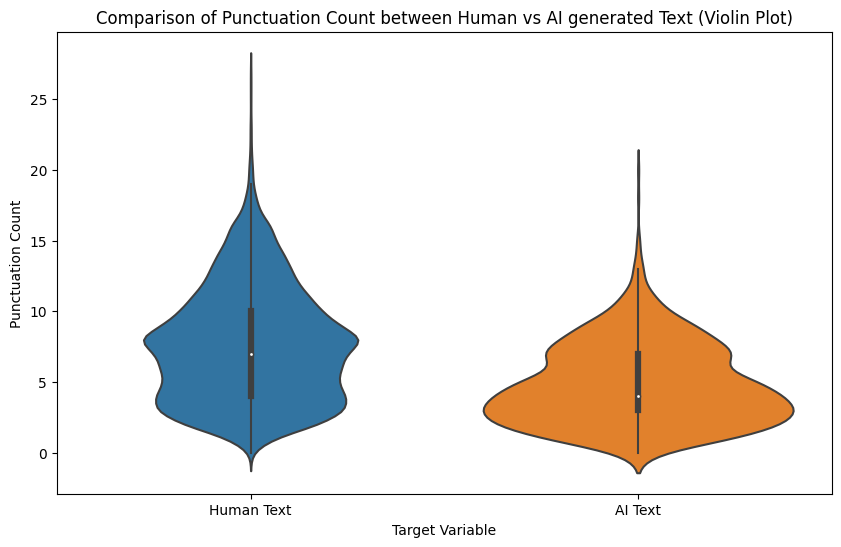

In [ ]:
# Violin plot to compare punctuation count between target variables
plt.figure(figsize=(10, 6))
sns.violinplot(x='ind', y='punc_num', data=df)
plt.title('Comparison of Punctuation Count between Human vs AI generated Text (Violin Plot)')
plt.xlabel('Target Variable')
plt.ylabel('Punctuation Count')
# Set custom x-axis labels
plt.xticks(ticks=[0, 1], labels=['Human Text', 'AI Text'])
plt.show()

From the violin plot, it can be observed that AI generated text typically has lower punctuation count than that of Human generated text.

### Word count and punctuation count comparisions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          11144 non-null  int64
 1   word_count  11144 non-null  int64
 2   punc_num    11144 non-null  int64
 3   ind         11144 non-null  int64
dtypes: int64(4)
memory usage: 348.4 KB


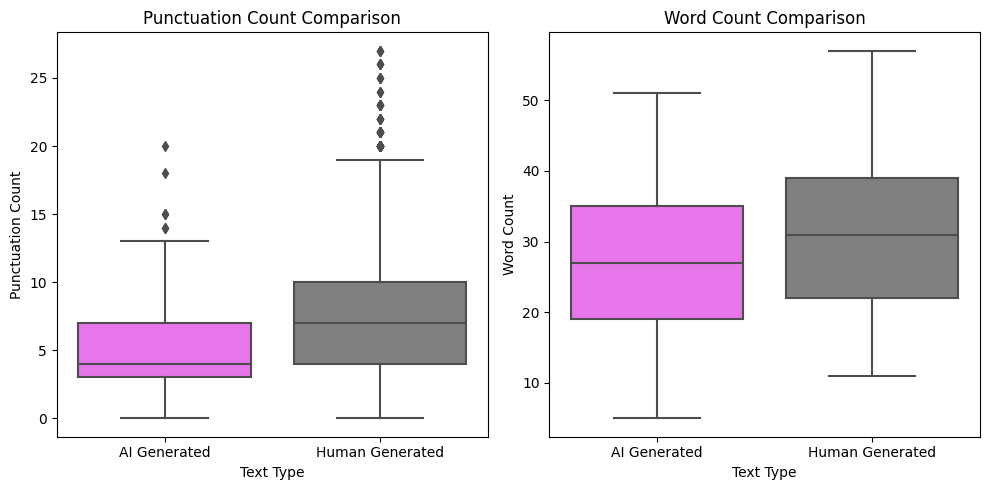

In [ ]:
# Remove word embeddings columns and see the statistics
df_no_text = df[["ID", "word_count", "punc_num", "ind"]]
df_no_text.info()

# Check if there's any difference between AI generated tweets and human generated tweets.

# word count
ai_text_word_count = df_no_text.loc[df["ind"] == 1, ["word_count"]]
human_text_word_count = df_no_text.loc[df["ind"] == 0, ["word_count"]]

stats_word_count = pd.concat([ai_text_word_count, human_text_word_count], axis=1)
stats_word_count.columns = ["AI", "Human"]
stats_word_count

# punctuation count
ai_text_punc_count = df_no_text.loc[df["ind"] == 1, ["punc_num"]]
human_text_punc_count = df_no_text.loc[df["ind"] == 0, ["punc_num"]]
stats_punc_count = pd.concat([ai_text_punc_count, human_text_punc_count], axis=1)
stats_punc_count.columns = ["AI", "Human"]
stats_punc_count
# Boxplot for punctuation count comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=[ai_text_punc_count, human_text_punc_count], palette=["#FA62FF", "grey"])
plt.xticks(ticks=[0, 1], labels=["AI Generated", "Human Generated"])
plt.xlabel("Text Type")
plt.ylabel("Punctuation Count")
plt.title("Punctuation Count Comparison")

# Boxplot for word count comparison
plt.subplot(1, 2, 2)
sns.boxplot(data=[ai_text_word_count, human_text_word_count], palette=["#FA62FF", "grey"])
plt.xticks(ticks=[0, 1], labels=["AI Generated", "Human Generated"])
plt.xlabel("Text Type")
plt.ylabel("Word Count")
plt.title("Word Count Comparison")

plt.tight_layout()
plt.show()


Human generated  text falls under wide range of values compared to ai generated values. Human generated text tends to have higher median punctuation count.


### Relationship between Word Count and Punctuation number

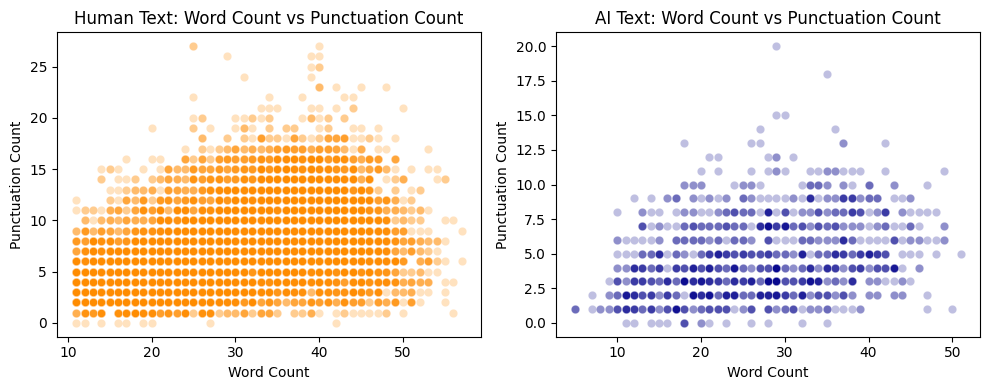

In [ ]:
# Create a 1x2 grid for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot for label 0
df_label_0 = df[df['ind'] == 0]
sns.scatterplot(x='word_count', y='punc_num', data=df_label_0, color='darkorange', alpha=0.25, ax=axes[0])
axes[0].set_title('Human Text: Word Count vs Punctuation Count')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Punctuation Count')

# Scatter plot for label 1
df_label_1 = df[df['ind'] == 1]
sns.scatterplot(x='word_count', y='punc_num', data=df_label_1, color='darkblue', alpha=0.25, ax=axes[1])
axes[1].set_title('AI Text: Word Count vs Punctuation Count')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Punctuation Count')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

There does not seem to be any increasing relationship between word count and punctuation number. Even at higher word counts like around 40-50, punctuation number ranges from as low as 0 through as high as 25.

### Use PCA to convert 768D to 2D for visualization

Explained Variance Ratio by top two princial Components:  [0.18221394 0.07443062]


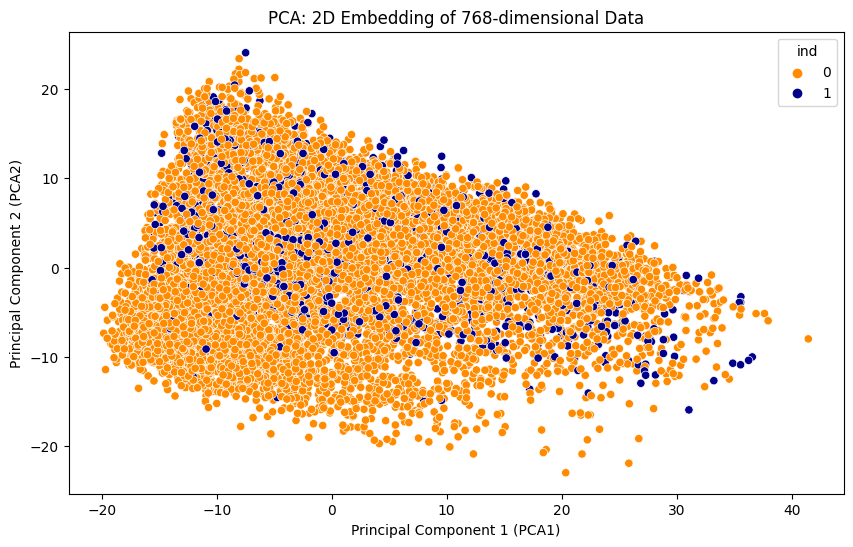

In [ ]:
embedding_feature_cols = [col for col in df.columns if 'feature' in col]
embeddings = df[embedding_feature_cols]
y_ind = df['ind']
# Standardize the features
embeddings = StandardScaler().fit_transform(embeddings)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
embeddings = pca.fit_transform(embeddings)
print("Explained Variance Ratio by top two princial Components: ", pca.explained_variance_ratio_)
# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(data={'PCA1': embeddings[:, 0], 'PCA2': embeddings[:, 1], 'ind': y_ind})

# Plot the reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='ind', data=df_pca, palette={0: 'darkorange', 1: 'darkblue'})
plt.title('PCA: 2D Embedding of 768-dimensional Data')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
# plt.legend(title='Category', labels=['ind=0', 'ind=1'])
plt.show()

Visualizing top two principal components that explain 25% of the variance (combined) in all the embeddings for AI vs Human generated text, we can observe that the data points are mostly overlapping and there is no clear seperation between the two clusters and model might struggle to classify just based on these two Principal Components alone. However, since this was solely for visualization purpose and including additional principal components could help in model classifying the data points better.

---



### Visualization with T-SNE

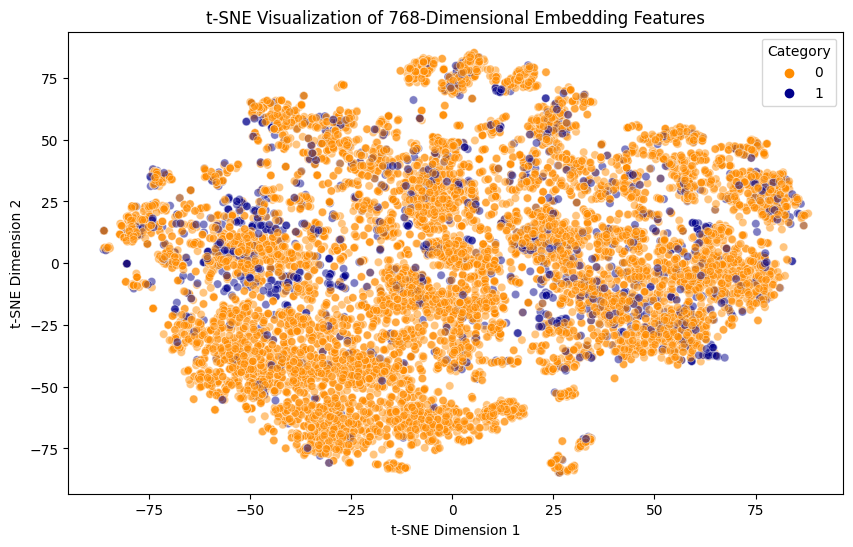

In [ ]:
# Extract features (X) and labels (y)
feature_cols = [col for col in df.columns if 'feature' in col]
X = df[feature_cols].values
y = df['ind'].values

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(data=X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['ind'] = y

# Plot the t-SNE visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne1', y='tsne2', hue='ind', data=df_tsne, palette={1: 'darkblue', 0: 'darkorange'}, alpha=0.5)
plt.title('t-SNE Visualization of 768-Dimensional Embedding Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Category')
plt.show()

T-SNE visualization shows that the clusters are not well seperated. Hence the model performance might not be too high.

## Feature Engineering

In [ ]:
epsilon = 0.001

# creating new features from 768D sentence embeddings to improve model performance
# for col in df.columns:
#   if "feature" in col:
#     # df[col+'_word'] = df[col]/(df['word_count'])
#     # df[col+'_punc'] = df[col]/(df['punc_num']+epsilon)
#     # df[col+'_word_punc'] = df[col]/(df['punc_num']+df['word_count'])
#     df[col+'_word'] = df[col]*(df['word_count'])
#     df.drop([col],axis=1,inplace=True)
#     # pass

df['word_per_punc'] = df['word_count']/(df['punc_num']+epsilon)
df['punc_per_word'] = df['punc_num']/(df['word_count'])
df['word_plus_punc'] = df['word_count']+df['punc_num']

## Train Test Split

In [ ]:
# Split data into X and y
X = df.drop(['ID','ind'],axis=1)
y = df['ind']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(11144, 773) (10029, 773) (1115, 773)
(11144,) (10029,) (1115,)


## Data Balancing

In [ ]:
# Highly imbalanced dataset - Need to balance both classes before modelling

# # # # # Create a SMOTETomek instance
# smote_tomek = SMOTETomek(sampling_strategy='auto')
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)


# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)


# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
#After resampling, check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(10029, 773)
(10029,)
0    9039
1     990
Name: ind, dtype: int64


## Standard Scaler

In [ ]:
# # Initialize the Standard Scaler
scaler = StandardScaler()

# Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## SVD for Dimension Reduction - doesn't yield best f1 score

In [ ]:
# # Perform SVD on the training data
# feature_cols=[col for col in X_train.columns if "feature" in col]
# print(len(feature_cols))
# n_components_svd = 350
# svd = TruncatedSVD(n_components=n_components_svd)  # Set the desired number of components (adjust as needed)
# X_train_svd = svd.fit_transform(X_train)
# X_train_svd = pd.DataFrame(X_train_svd, columns=[f'SVD_{i}' for i in range(n_components_svd)])
# # Transform the test data using the same SVD object
# X_test_svd = svd.transform(X_test)
# X_test_svd = pd.DataFrame(X_test_svd, columns=[f'SVD_{i}' for i in range(n_components_svd)])
# X_train = pd.concat([X_train_svd, X_train.iloc[:,-2:]], axis=1)
# X_test = pd.concat([X_test_svd, X_test.iloc[:,-2:]], axis=1)
# print(X_train.shape)
# print(X_test.shape)

## PCA for dimensionality reduction - doesn't yield best f1 score

In [ ]:
# # apply PCA on text embeddings to reduce dimensionality
# pca = PCA(n_components = 0.99) #, svd_solver = 'full'
# feature_cols=[col for col in X_train.columns if "feature" in col]
# other_cols = [col for col in X_train.columns if "feature" not in col]
# print(len(feature_cols))
# X_train_pca = pca.fit_transform(X_train[feature_cols])
# X_test_pca = pca.transform(X_test[feature_cols])
# print(pca.n_components_)
# X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
# X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(pca.n_components_)])
# X_train = pd.concat([X_train_pca, X_train[other_cols]], axis=1)
# X_test = pd.concat([X_test_pca, X_test[other_cols]], axis=1)
# print(X_train.shape)
# print(X_test.shape)

## Modelling

### Model Architecutre

In [ ]:
from keras.initializers import glorot_normal, he_normal, lecun_normal, random_normal

In [ ]:
model = Sequential()
model.add(Dense(400, input_shape=(X_train.shape[1],), activation='relu')) #,kernel_regularizer=l1(0.01)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(200, activation='relu')) #, kernel_initializer=he_normal()
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(80, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               309600    
                                                                 
 batch_normalization (Batch  (None, 400)               1600      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 batch_normalization_1 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 200)               0

### Compile model

### Calculation of F1-Score

In [ ]:
#code for monitoring f1 score during training
# Custom F1 score metric class
class F1ScoreMetric(Metric):
    def __init__(self, **kwargs):
        super(F1ScoreMetric, self).__init__(**kwargs)
        self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.round(y_pred), tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

### Compile Model

In [ ]:
# compile the model
# using adam optimizer, binary cross entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',F1ScoreMetric()]) #f1

# earlystopping with any value of patience, return best weights
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights = True)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(10029, 773)
(1115, 773)


### Fit Model

In [ ]:
#return history to plot the losses as learning progresses
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es], epochs=10000,  #
                    batch_size=10, shuffle=True,
                    verbose=1)

Epoch 1/10000
1003/1003 [==============================] - 13s 11ms/step - loss: 0.3719 - accuracy: 0.8494 - f1_score_metric: 0.2627 - val_loss: 0.2081 - val_accuracy: 0.9318 - val_f1_score_metric: 0.5309
Epoch 2/10000
1003/1003 [==============================] - 10s 10ms/step - loss: 0.2456 - accuracy: 0.9146 - f1_score_metric: 0.4383 - val_loss: 0.1887 - val_accuracy: 0.9408 - val_f1_score_metric: 0.6118
Epoch 3/10000
1003/1003 [==============================] - 9s 9ms/step - loss: 0.2170 - accuracy: 0.9275 - f1_score_metric: 0.5337 - val_loss: 0.1709 - val_accuracy: 0.9507 - val_f1_score_metric: 0.6893
Epoch 4/10000
1003/1003 [==============================] - 10s 10ms/step - loss: 0.2033 - accuracy: 0.9300 - f1_score_metric: 0.5585 - val_loss: 0.1743 - val_accuracy: 0.9435 - val_f1_score_metric: 0.6228
Epoch 5/10000
1003/1003 [==============================] - 9s 9ms/step - loss: 0.1923 - accuracy: 0.9334 - f1_score_metric: 0.5871 - val_loss: 0.1594 - val_accuracy: 0.9534 - val_f1_

### Save Model

In [ ]:
model.save('/content/ModelReport/AI_textGeneration_v1.h5', overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Evaluation

### Classification Report

In [ ]:
##########  Classification Report on Train Predictions  #############
#predict on Test partitions
train_preds = (model.predict(X_train) > 0.5).astype(int)
report = classification_report(y_train, train_preds)
print ("############# Train Classification Report ###############")
print(report)



##########  Classification Report on Test Predictions  #############
#predict on Test partitions
test_preds = (model.predict(X_test) > 0.5).astype(int)
report = classification_report(y_test, test_preds)
print ("############# Test Classification Report ###############")
print(report)

314/314 [==============================] - 1s 3ms/step
############# Train Classification Report ###############
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9039
           1       0.97      0.89      0.93       990

    accuracy                           0.99     10029
   macro avg       0.98      0.94      0.96     10029
weighted avg       0.99      0.99      0.99     10029

35/35 [==============================] - 0s 4ms/step
############# Test Classification Report ###############
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1005
           1       0.84      0.68      0.75       110

    accuracy                           0.96      1115
   macro avg       0.90      0.83      0.86      1115
weighted avg       0.95      0.96      0.95      1115



In [ ]:
print("Overall F1 score on Training Data: ",f1_score(y_train, train_preds))
print("Overall F1 score on Test Data: ",f1_score(y_test, test_preds))

Overall F1 score on Training Data:  0.9276281035393554
Overall F1 score on Test Data:  0.7537688442211055


### Learning curves for Loss

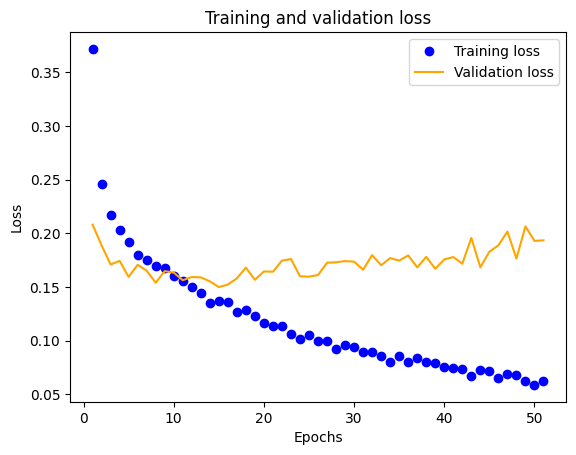

In [ ]:
#learning curve for train and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training loss gradually decreases, while validation loss decreases until a point and starts to increase thereafter. Model might have started to overfit at this point. Further model training is stopped because of early stopping callback.

### Learning curves for accuracy

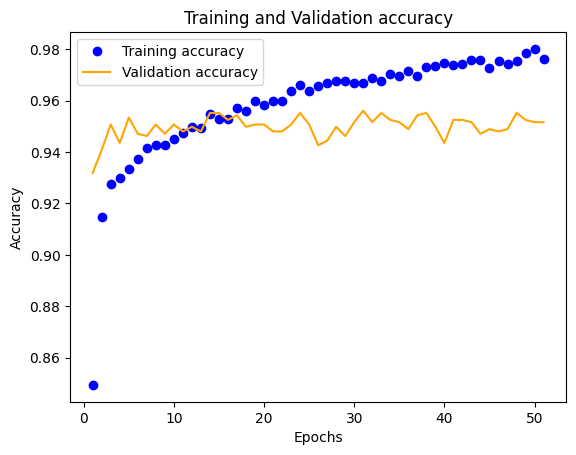

In [ ]:
#learning curve for train and validation accuracy
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'orange', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Validation accuracy starts at a high value for initial epochs and has only little improvement, with some fluctuations as the training continues. However, early stopping callback returns the model weights that resulted in best validation accuracy.

### Confusion Matrix

In [ ]:
#create confusion matrix for train and test partitions
confusion_train = confusion_matrix(y_train, train_preds)
confusion_test = confusion_matrix(y_test, test_preds)
print(confusion_train)
print(confusion_test)

[[9014   25]
 [ 112  878]]
[[991  14]
 [ 35  75]]


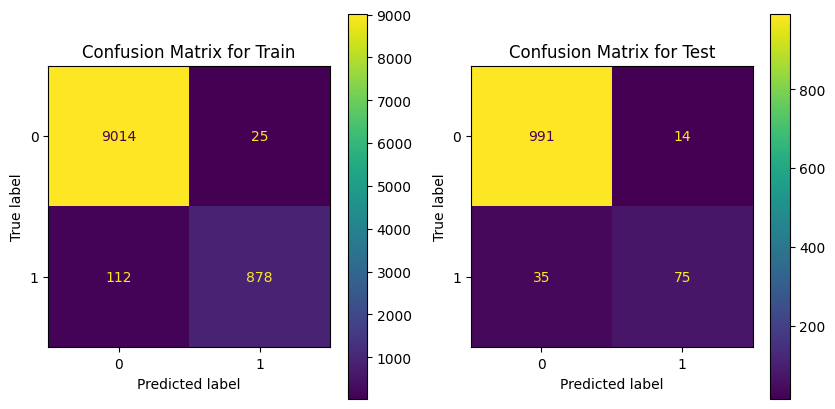

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

#Display confusion matrix for Train
display_train = ConfusionMatrixDisplay(confusion_train, display_labels=[0,1])
ax[0].set(title='Confusion Matrix for Train')
display_train.plot(ax=ax[0])


#Display confusion Matrix for Test
display_test = ConfusionMatrixDisplay(confusion_test, display_labels=[0,1])
ax[1].set(title='Confusion Matrix for Test')
display_test.plot(ax=ax[1])

Model makes reasonable number of accurate predictions. Although the false positives are a bit lower, false negatives are a bit high. Hence the model has high precision and relatively lower recall.

## Permutation Importance - important features

In [ ]:
# Define a custom scoring function compatible with Keras models
def keras_scorer(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    return accuracy_score(y_true, y_pred_binary)

In [ ]:
# Use permutation_importance with the custom scoring function
custom_scorer = make_scorer(keras_scorer, greater_is_better=True)
result = permutation_importance(model, X_test, y_test, scoring=custom_scorer, n_repeats=5, random_state=42)



35/35 [==============================] - 0s 5ms/step


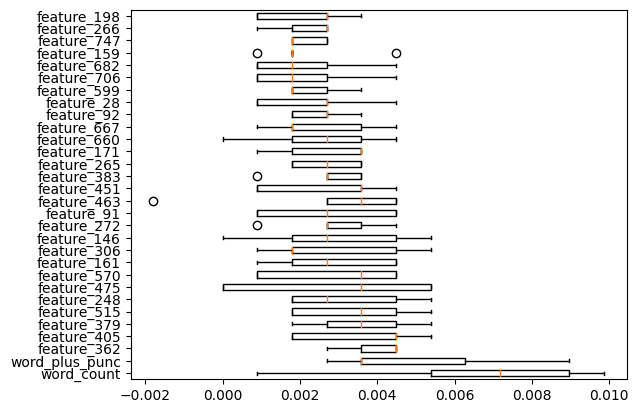

In [ ]:
# Get the feature importances and their indices
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Display the top 30 features
top_30_features = indices[:30]

plt.boxplot(result.importances[top_30_features].T, vert=False,
            labels=X.columns[top_30_features])
fig.suptitle('Neural Network Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

From the permutation importance plot, word_count and (word_count + punc_num) are the top features that led to highest change in test accuracy. Few embedding features also have an impact on model performance. However, they are not directly interpretable.

## Observations

* **Limitation for feature Engineering:** Since most of the data we have are sentence embeddings, its difficult to interpret these features directly and create new relevant features that can improve the model performance. Further, there was no detail provided on how these sentence embeddings are generated. Hence this posed as a limitation in creating new features. However, we made use of two interpretable features word_count and punc_num to create new features like punctuation density (punc_num/word_count) that can capture the number of punctuations used for a specific number of words, (word_count+punc_num), (word_count/punc_num).
* **Dimension Reduction Experiments:** We have tried various dimension reduction methods like PCA, SVD, Lasso based feature selection, Random Forest model based feature selection to reduce 768D embedding vector to lower dimension. For SVD & PCA, we have retained features such that they retain 95-99% of the variance in the actual data, which led to final dimension of ~300-450 features. However, our neural network performance was a bit poor with reduced dimension features. When we input all the 768 features as they are, we got a better F1 score than when we used principal components. However, by doing so, we are trading off model complexity for a better F1 score.
* **Monitoring F1 score during training:** Since our model is evaluated based on F1 score, we wanted to track and monitor f1 score for each epoch. Hence we created a custom function using tensorflow operations that can monitor and print out f1 score for each epoch.
* **Choice of Model:** We considered experimenting with RNN. But since RNNs work best in capturing sequential information in the data, we have no idea if the sentence embeddings carry this sequential information. Sentences with higher and lower length are both converted to 768 dimensional embedding. Embeddings of two sentences with similar meaning would be closer to each other regardless of their word count. Hence, we haven't exeperimented with RNNs with this kind of data. Further, in the model architecture adding a lot of layers overfit the model. Hence we used a minimal architecture that led to minimal difference in accuracy and f1 scores between train and test partitions.
* **Class Imbalance:** We experimented with various class balancing techniques like SMOTE, over sampling and undersampling, SMOTETomek. Based on our observation, undersampling led to poor performance. With oversampling, SMOTE/SMOTETomek techniques, we could see that the f1 score on the training data was much higher than that of validation data. Hence the model might be overfitting to the overly sampled training data. Adjusting model architecture didnt help reduce this overfitting. Hence we chose to not use any resampling techniques to balance the data. Without balancing the data, our model has a high precision(0.84) and relatively lower recall (0.68).
* **permutation importance and PDP:** Permutation importance plot indicate that word_count and (word_count+punc_num) are top two features that most impact the model performance. We initially run permutation importance with n_repeats = 10, but it was taking quite long time to run, hence we chose to re-run with n_repeats=5. By doing so, results might be highly variable and might be less statistically significant.